In [1]:
import numpy as np
from scipy.special import gamma as gamma_function
from scipy.optimize import minimize
from scipy.stats import gamma
import matplotlib.pyplot as plt
import pydtmc as mc
from scipy.linalg import expm
import pandas as pd
df = pd.read_csv('autoclaims.csv')
clmdata = df[["PAID"]].sort_values(by="PAID").reset_index(drop=True).to_numpy()[int(0.2*len(df)):-int(0.05*len(df))]

In [2]:
T = np.array([[-0.1,0.05],
     [0.2,-0.3]])
alpha = np.array([0.75,0.25])

In [3]:
def S(x):
    return alpha @ expm(T*x) @ np.ones(2)
def qsolverS(x):
    return abs(S(x) - 0.01)

In [4]:
minimize(qsolverS, bounds = [(70,80)], x0 = [75])['x'][0]

78.3768417807779

Parameters for the mixed data:
Weights: [6.25104167e-001 1.13597277e-101 7.73054721e-133 3.26576017e-101
 2.93853344e-073 3.65578395e-051 7.07705834e-034 1.84605017e-020
 1.64350825e-009 3.74895831e-001]
Alphas: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Shared Beta: 0.07244149917308308


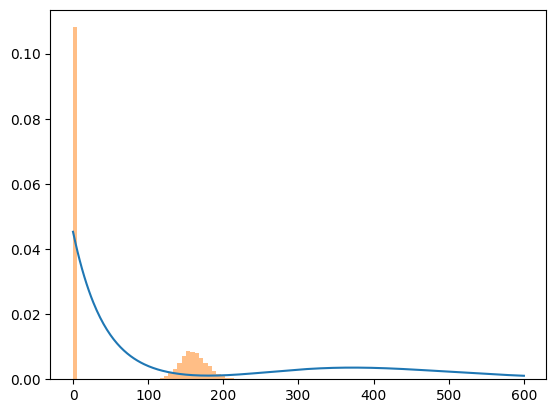

In [42]:
def gamma_pdf(x, alpha, beta):
    """Gamma PDF function for shape alpha and rate beta."""
    return (beta**alpha) * (x**(alpha-1)) * np.exp(-beta*x) / gamma_function(alpha)
def mixed_pdf(x,alpha,beta,w):
    return np.dot(w,[gamma_pdf(x,a,beta) for a in alpha])
    
# EM algorithm for fitting a mixture of Gamma distributions with shared beta and integer alphas
def em_mixture_gamma_shared_beta_integer_alpha(data, n_components=2, max_iter=1000, tol=1e-6):
    # Initial guesses for parameters
    alpha_range=(1, n_components+1)
    weights = np.ones(n_components) / n_components
    alphas = [_ for _ in range(1, n_components+1)]#np.random.randint(alpha_range[0], alpha_range[1]+1, size=n_components)
    beta = np.random.rand() + 1

    n = len(data)
    log_likelihood_old = -np.inf

    for iteration in range(max_iter):
        # E-step: Compute responsibilities
        responsibilities = np.zeros((n, n_components))
        for i in range(n_components):
            responsibilities[:, i] = weights[i] * gamma_pdf(data, alphas[i], beta)
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # M-step: Update parameters
        weights = responsibilities.mean(axis=0)
       
        # Optimize shared beta
        def negative_log_likelihood_beta(beta):
            sum_ll = 0
            for j in range(n_components):
                sum_ll += np.sum(np.log(gamma_pdf(data, alphas[j], beta)) * responsibilities[:, j])
            return -sum_ll

        result_beta = minimize(negative_log_likelihood_beta, x0=[beta], method='L-BFGS-B', bounds=[(1e-5, None)])
        beta = result_beta.x[0]

        # Check for convergence
        log_likelihood_new = -result_beta.fun
        if np.abs(log_likelihood_new - log_likelihood_old) < tol:
            break
        log_likelihood_old = log_likelihood_new

    return weights, alphas, beta

# Generate synthetic data
np.random.seed(42)
n_samples = 1000
data1 = np.random.pareto(3, size=int(3*n_samples))
data2 = np.random.pareto(5, size=int(2*n_samples))
#data3 = gamma.rvs(a=80, scale=2, size=int(3*n_samples))
mixed_data = np.concatenate([data1, data2, data3])

# Fit the model to the mixed data
weights_mixed, alphas_mixed, shared_beta_mixed = em_mixture_gamma_shared_beta_integer_alpha(mixed_data, n_components=10)

print("Parameters for the mixed data:")
print("Weights:", weights_mixed)
print("Alphas:", alphas_mixed)
print("Shared Beta:", shared_beta_mixed)
plt.plot(np.linspace(0,600,400), mixed_pdf(np.linspace(0,200,400), alphas_mixed, shared_beta_mixed, weights_mixed))
plt.hist(mixed_data,bins=40,alpha=0.5,density=True)
plt.show()

In [6]:
%%time
weights_mixed, alphas_mixed, shared_beta_mixed = em_mixture_gamma_shared_beta_integer_alpha(mixed_data, n_components=1)

CPU times: user 11.3 ms, sys: 84 ms, total: 95.3 ms
Wall time: 7.46 ms


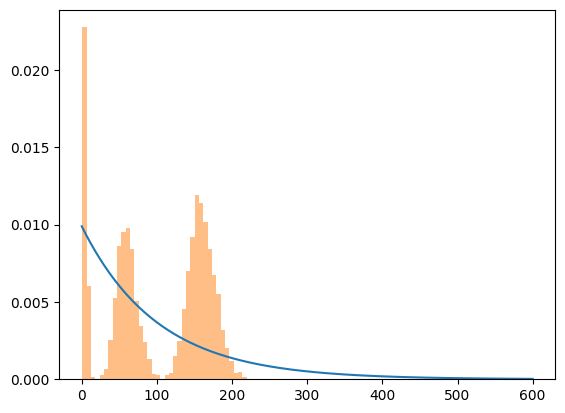

In [7]:
plt.plot(np.linspace(0,600,400), mixed_pdf(np.linspace(0,600,400), alphas_mixed, shared_beta_mixed, weights_mixed))
plt.hist(mixed_data,bins=40,alpha=0.5,density=True)
plt.show()

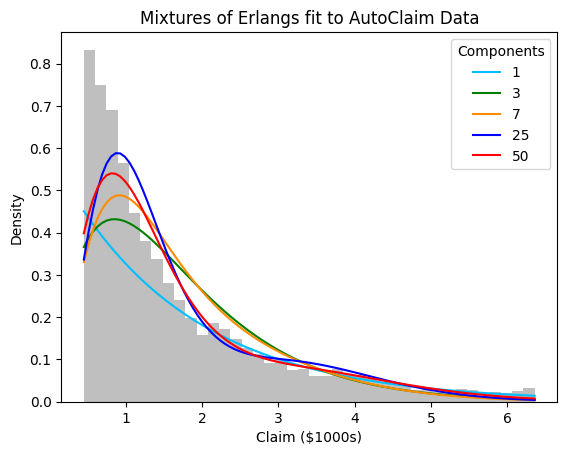

In [77]:
data = np.array(clmdata).reshape((5081,))/1000
colors = ["deepskyblue", "green", "darkorange", "blue", "red"]
n_components = [1, 3, 7, 25, 50]
for n in range(len(n_components)):
    weights_mixed, alphas_mixed, shared_beta_mixed = em_mixture_gamma_shared_beta_integer_alpha(data, n_components=n_components[n])
    plt.plot(np.linspace(min(data),max(data),100), mixed_pdf(np.linspace(min(data),max(data),100), alphas_mixed, shared_beta_mixed, weights_mixed),color=colors[n])
plt.hist(data,bins=40,density=True,alpha=0.5,color="gray")
plt.legend(n_components, title = "Components")
plt.title("Mixtures of Erlangs fit to AutoClaim Data")
plt.xlabel("Claim ($1000s)")
plt.ylabel("Density")
plt.show()

In [ ]:
ssdata = np.array([1114, 215, 662, 728, 594, 970, 882, 613, 509, 318, 1106, 641, 899, 348, 840, 436, 313, 295, 144, 577, 783, 1084, 506, 626, 227, 741, 761, 1251, 462, 664, 779, 952, 828, 741, 357, 953, 329, 378, 1183, 873, 607, 506, 740, 753, 685, 483, 636, 461, 462, 1143, 538, 675, 1183, 646, 398, 587, 1365, 815, 473, 130, 522])
ssdata = ssdata * (12/365)
data

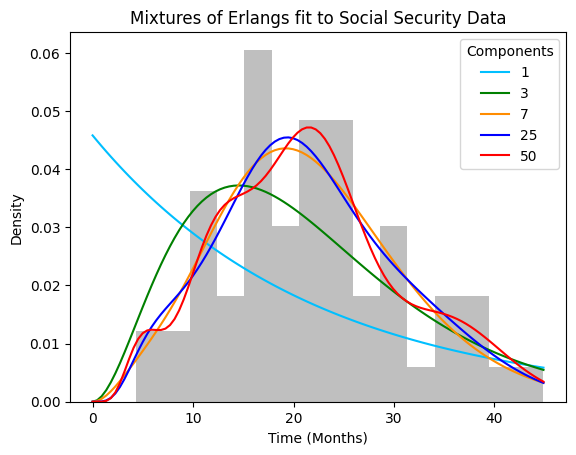

In [76]:
n_components = [1, 3, 7, 25, 50]
colors = ["deepskyblue", "green", "darkorange", "blue", "red"]
for n in range(len(n_components)):
    weights_mixed, alphas_mixed, shared_beta_mixed = em_mixture_gamma_shared_beta_integer_alpha(ssdata, n_components=n_components[n])
    plt.plot(np.linspace(0,max(ssdata),100), mixed_pdf(np.linspace(0,max(ssdata),100), alphas_mixed, shared_beta_mixed, weights_mixed),c=colors[n])
plt.hist(ssdata,bins=15,density=True,alpha=0.5,color="gray")
plt.legend(n_components, title = "Components")
plt.title("Mixtures of Erlangs fit to Social Security Data")
plt.xlabel("Time (Months)")
plt.ylabel("Density")
plt.show()

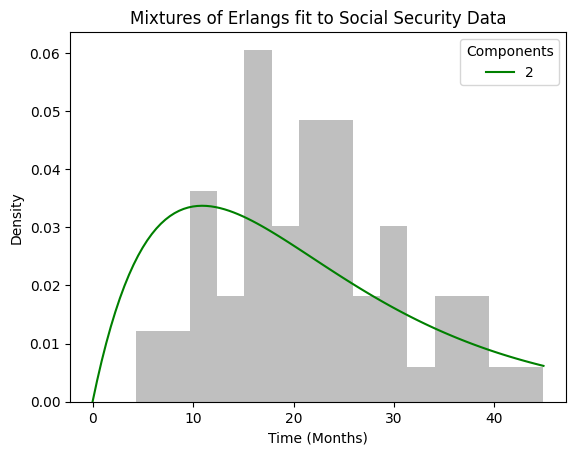

CPU times: user 208 ms, sys: 11.3 ms, total: 219 ms
Wall time: 101 ms


In [78]:
%%time
n_components = [2]
colors = ["green"]
for n in range(len(n_components)):
    weights_mixed, alphas_mixed, shared_beta_mixed = em_mixture_gamma_shared_beta_integer_alpha(ssdata, n_components=n_components[n])
    plt.plot(np.linspace(0,max(ssdata),100), mixed_pdf(np.linspace(0,max(ssdata),100), alphas_mixed, shared_beta_mixed, weights_mixed),c=colors[n])
plt.hist(ssdata,bins=15,density=True,alpha=0.5,color="gray")
plt.legend(n_components, title = "Components")
plt.title("Mixtures of Erlangs fit to Social Security Data")
plt.xlabel("Time (Months)")
plt.ylabel("Density")
plt.show()

Parameters for the mixed data:
Weights: [3.39064837e-001 0.00000000e+000 0.00000000e+000 0.00000000e+000
 6.02903110e-245 1.37677844e-133 6.13774630e-064 9.33726527e-024
 5.22809237e-005 7.94277682e-002 4.85487150e-009 1.59069913e-021
 2.09734909e-034 8.60425228e-044 1.99387161e-047 9.74953222e-045
 6.32121643e-037 5.54915055e-026 1.29943507e-013 5.81455109e-001]
Alphas: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Shared Beta: 0.13924299153820302


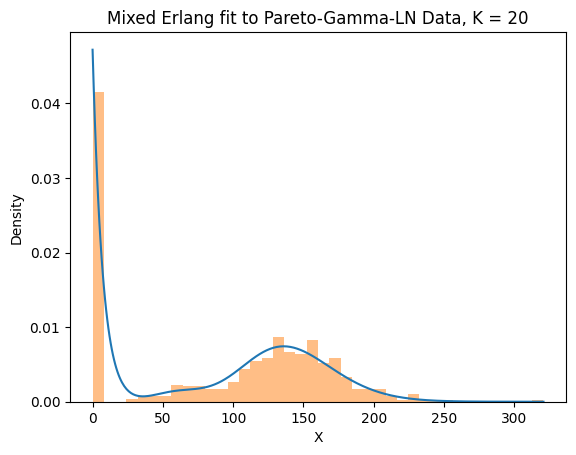

In [104]:
# Generate synthetic data
np.random.seed(42)
n_samples = 100
data1 = np.random.lognormal(5,0.2, size=int(3*n_samples))
data2 = np.random.pareto(5, size=int(2*n_samples))
data3 = gamma.rvs(a=5, scale=20, size=int(n_samples))
mixed_data = np.concatenate([data1, data2,data3])

# Fit the model to the mixed data
weights_mixed, alphas_mixed, shared_beta_mixed = em_mixture_gamma_shared_beta_integer_alpha(mixed_data, n_components=20)

print("Parameters for the mixed data:")
print("Weights:", weights_mixed)
print("Alphas:", alphas_mixed)
print("Shared Beta:", shared_beta_mixed)
plt.plot(np.linspace(0,max(mixed_data),400), mixed_pdf(np.linspace(0,max(mixed_data),400), alphas_mixed, shared_beta_mixed, weights_mixed))
plt.hist(mixed_data,bins=40,alpha=0.5,density=True)
plt.title("Mixed Erlang fit to Pareto-Gamma-LN Data, K = 20")
plt.xlabel("X")
plt.ylabel("Density")
plt.show()